# Import libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.models import vgg16, VGG16_Weights
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
from PIL import Image
import os
import numpy as np

# Database creations using pytorch Dataset 

In [7]:
class ImageQualityDataset(Dataset):
    """Dataset for image quality assessment."""

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the CSV file with annotations.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        """Returns the number of samples in the dataset."""
        return len(self.data)

    def __getitem__(self, idx):
        """
        Retrieves an image and its labels by index.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: A tuple (image, labels) where:
                image (PIL.Image): The image.
                labels (torch.Tensor): Tensor containing quality and authenticity scores.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(os.getcwd(), self.data.iloc[idx, 3])  # image_path column
        image = Image.open(img_name).convert('RGB')
        quality = self.data.iloc[idx, 0]  # Quality column
        authenticity = self.data.iloc[idx, 1]  # Authenticity column
        labels = torch.tensor([quality, authenticity], dtype=torch.float)


        if self.transform:
            image = self.transform(image)

        return image, labels


# Definitions of the models

In [8]:
class QualityPredictor(nn.Module):
    def __init__(self, freeze_backbone=True):
        super().__init__()
        # Load pre-trained VGG16
        vgg = vgg16(weights=VGG16_Weights.DEFAULT)
        
        # Freeze backbone if requested
        if freeze_backbone:
            for param in vgg.features.parameters():
                param.requires_grad = False
                
        # Extract features up to fc2
        self.features = vgg.features
        self.avgpool = vgg.avgpool
        self.fc1 = vgg.classifier[:-1]  # Up to fc2 (4096 -> 128)
        
        # New regression head
        self.regression_head = nn.Sequential(
            nn.Linear(4096, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 2)  # Predict quality and realness
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        features = self.fc1(x)
        predictions = self.regression_head(features)
        return predictions, features

## Setup section

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data transformations for the ImageNet dataset
data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

annotations_file = 'Dataset/AIGCIQA2023/mos_data.csv'

# Create the dataset
dataset = ImageQualityDataset(csv_file=annotations_file, transform=data_transforms)

# Set random seeds for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

# Split the dataset into training, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


# Create data loaders
BATCH_SIZE = 64
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Create a dictionary containing the data loaders
dataloaders = {
    'train': train_dataloader,
    'val': val_dataloader,
    'test': test_dataloader
}



# Models loading

In [10]:
BASELINE_MODEL_PATH = 'Models/VGG-16_finetuned_regression.pth'
NOISY_PRUNED_MODEL_PATH = 'Models/noise_out_pruned_model.pth'
NEGATIVE_IMPACT_PRUNED_MODEL_PATH = 'Models/negative_impact_pruned_model.pth'

noisy_pruned_model = QualityPredictor()
noisy_pruned_model.load_state_dict(torch.load(NOISY_PRUNED_MODEL_PATH, weights_only=True))

negative_impact_pruned_model = QualityPredictor()
negative_impact_pruned_model.load_state_dict(torch.load(NEGATIVE_IMPACT_PRUNED_MODEL_PATH,weights_only=True))

baseline_model = QualityPredictor()
baseline_model.load_state_dict(torch.load(BASELINE_MODEL_PATH,weights_only=True))

<All keys matched successfully>

# 1) Sort the importance scores by channel ID and normalize them to sum to 1

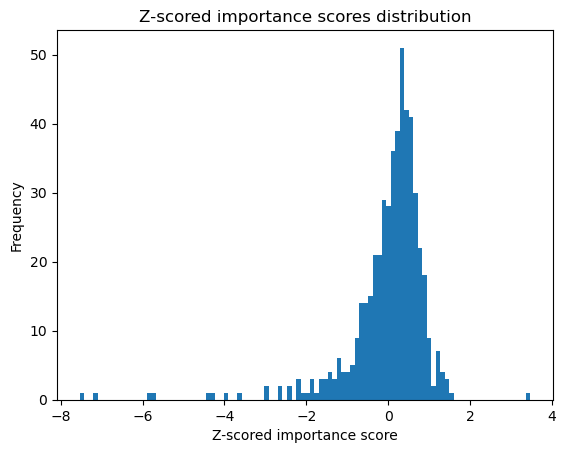

In [ ]:
#set numpy print options
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)
importance_scores = np.load('Ranking_arrays/importance_scores.npy')
# Sort the importance scores by channel index to replace the original position of the channel
sorted_by_index_scores = importance_scores[importance_scores[:, 0].argsort()][:,1]

def z_scores(scores):
    return (scores - np.mean(scores)) / np.std(scores)

z_scored_importance_scores = z_scores(sorted_by_index_scores)

#plot the z-scored importance scores distribution
import matplotlib.pyplot as plt
plt.hist(z_scored_importance_scores, bins=100)
plt.title('Z-scored importance scores distribution')
plt.xlabel('Z-scored importance score')
plt.ylabel('Frequency')
plt.show()


# 2) Extracting the activations of the last convolutional layer for the images in the dataset

In [29]:

class FeatureMapHook:
    """Hook to extract feature maps from neural network layers."""
    
    def __init__(self):
        self.feature_maps = []
    
    def __call__(self, module, input, output):
        # Detach from computation graph and move to CPU
        self.feature_maps.append(output.detach().cpu())

def get_feature_maps(model, dataloader, layer_name, device):
    """
    Extracts the feature maps of a specific layer from a model.
    
    Args:
        model (nn.Module): The neural network model.
        dataloader (DataLoader): DataLoader for evaluation.
        layer_name (str): The name of the layer to extract feature maps from.
        device (str): Device to run the model on ('cuda' or 'cpu').
        
    Returns:
        np.ndarray: The feature maps as a numpy array with shape (240, num_features).
    """
    # Set model to evaluation mode
    model.eval()
    model.to(device)
    
    # Register a hook to extract feature maps
    hook = FeatureMapHook()
    target_layer = dict(model.named_modules())[layer_name]
    hook_handle = target_layer.register_forward_hook(hook)
    
    # Forward pass to extract feature maps from the dataloader
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            model(inputs)

    # Remove the hook
    hook_handle.remove()
    
    # Process the feature maps to get the desired shape
    all_features = []
    
    for batch_features in hook.feature_maps:
        # Add batch features to our collection
        all_features.append(batch_features)
    
    # Concatenate all batches and convert to numpy
    features_tensor = torch.cat(all_features, dim=0)
    
    # Ensure we have exactly the number of samples we expect in the dataloader 
    assert features_tensor.shape[0] == len(dataloader.dataset) 
    
    # Convert to numpy array
    features_array = features_tensor.numpy()
    
    return features_array

test_functions_dataloader = DataLoader(torch.utils.data.Subset(val_dataset, range(20)), 
                                     batch_size=20, 
                                     shuffle=False, 
                                     num_workers=10)

layer_28_feature_maps_base = get_feature_maps(baseline_model, test_functions_dataloader, 'features.28', device)
layer_28_feature_maps_noisy = get_feature_maps(noisy_pruned_model, test_functions_dataloader, 'features.28', device)
layer_28_feature_maps_neg_impact = get_feature_maps(negative_impact_pruned_model, test_functions_dataloader, 'features.28', device)

shape_base = layer_28_feature_maps_base.shape
shape_noisy = layer_28_feature_maps_noisy.shape
shape_neg_impact = layer_28_feature_maps_neg_impact.shape

print(f'Feature maps shape for the baseline model: {shape_base}')
print(f'Feature maps shape for the noisy pruned model: {shape_noisy}')
print(f'Feature maps shape for the negative impact pruned model: {shape_neg_impact}')


Feature maps shape for the baseline model: (20, 512, 14, 14)
Feature maps shape for the noisy pruned model: (20, 512, 14, 14)
Feature maps shape for the negative impact pruned model: (20, 512, 14, 14)


## 2.1) Analyze the activations of the last convolutional layer

In [49]:
def get_zeroed_feature_maps(model, layer_name):
    """
    Get the indices of the zeroed out feature maps in a convolutional layer.

    Args:
        model (nn.Module): The neural network model.
        layer_name (str): The name of the convolutional layer.

    Returns:
        list: The indices of the zeroed out feature maps.
        int: The number of zeroed out feature maps.
    """
    dict_modules = dict(model.named_modules())
    layer = dict_modules[layer_name]
    zeroed_feature_maps = []

    for i, weight in enumerate(layer.weight):
        if torch.all(weight == 0):
            zeroed_feature_maps.append(i)
    zeroed_feature_maps.sort()
    #coverto to 0-based indexing
    zeroed_feature_maps = [i-1 for i in zeroed_feature_maps]

    num_zeroed = len(zeroed_feature_maps)

    return zeroed_feature_maps, num_zeroed

def analyze_feature_map_activations_zeros(feature_maps, model_name):
    """
    Analyzes zero-valued activations in feature maps.
    
    Args:
        feature_maps (numpy.ndarray): Feature maps with shape (n_samples, n_channels, height, width)
        model_name (str): Name of the model for reporting
        
    Returns:
        None: Prints statistics about zero activations
    """
    # Get dimensions
    n_samples, n_channels, height, width = feature_maps.shape
    total_elements = n_samples * height * width  # Total elements per channel
    
    # Initialize counters
    fully_zeroed_channels = 0
    channel_zero_percentages = []
    
    # Analyze each channel
    for channel_idx in range(n_channels):
        # Get activations for this channel across all samples and spatial locations
        channel_activations = feature_maps[:, channel_idx, :, :]
        
        # Count zeros in this channel
        zero_count = np.sum(channel_activations == 0)
        zero_percentage = (zero_count / total_elements) * 100
        channel_zero_percentages.append(zero_percentage)
        
        # Check if channel is completely zeroed
        if zero_percentage == 100:
            fully_zeroed_channels += 1
    
    # Calculate overall statistics
    avg_zero_percentage = np.mean(channel_zero_percentages)
    median_zero_percentage = np.median(channel_zero_percentages)
    
    # Count channels with different zero percentages
    high_zero_channels = sum(p >= 90 for p in channel_zero_percentages)  # >90% zeros
    medium_zero_channels = sum(50 <= p < 90 for p in channel_zero_percentages)  # 50-90% zeros
    low_zero_channels = sum(10 <= p < 50 for p in channel_zero_percentages)  # 10-50% zeros
    sparse_zero_channels = sum(p < 10 for p in channel_zero_percentages)  # <10% zeros
    
    # Print results
    print(f"\n===== {model_name} Zero Activation Analysis =====")
    print(f"Completely zeroed channels: {fully_zeroed_channels} out of {n_channels} ({fully_zeroed_channels/n_channels*100:.2f}%)")
    print(f"Average percentage of zeros per channel: {avg_zero_percentage:.2f}%")
    print(f"Median percentage of zeros per channel: {median_zero_percentage:.2f}%")
    print("\nChannel distribution by zero percentage:")
    print(f"  - Fully zeroed (100%): {fully_zeroed_channels} channels")
    print(f"  - Mostly zeroed (90-99.9%): {high_zero_channels - fully_zeroed_channels} channels")
    print(f"  - Medium zeros (50-89.9%): {medium_zero_channels} channels")
    print(f"  - Low zeros (10-49.9%): {low_zero_channels} channels")
    print(f"  - Sparse zeros (<10%): {sparse_zero_channels} channels")
    
    return channel_zero_percentages  # Return for further analysis if needed

_, baseline_model_num_zeroed = get_zeroed_feature_maps(baseline_model, 'features.28')

_, noisy_num_zeroed = get_zeroed_feature_maps(noisy_pruned_model, 'features.28')

_, negative_impact_num_zeroed = get_zeroed_feature_maps(negative_impact_pruned_model, 'features.28')

# Analyze each model's feature maps
baseline_zero_percentages = analyze_feature_map_activations_zeros(layer_28_feature_maps_base, "Baseline Model")
noisy_zero_percentages = analyze_feature_map_activations_zeros(layer_28_feature_maps_noisy, "Noisy Pruned Model")
negative_impact_zero_percentages = analyze_feature_map_activations_zeros(layer_28_feature_maps_neg_impact, "Negative Impact Pruned Model")


print("\n===== Comparison: Zeroed Weights vs. Zeroed Activations =====")
print(f"Baseline model: {baseline_model_num_zeroed} zeroed weight channels, {sum(np.array(baseline_zero_percentages) == 100)} zeroed activation channels")
print(f"Noisy pruned model: {noisy_num_zeroed} zeroed weight channels, {sum(np.array(noisy_zero_percentages) == 100)} zeroed activation channels")
print(f"Negative impact model: {negative_impact_num_zeroed} zeroed weight channels, {sum(np.array(negative_impact_zero_percentages) == 100)} zeroed activation channels")





===== Baseline Model Zero Activation Analysis =====
Completely zeroed channels: 0 out of 512 (0.00%)
Average percentage of zeros per channel: 0.00%
Median percentage of zeros per channel: 0.00%

Channel distribution by zero percentage:
  - Fully zeroed (100%): 0 channels
  - Mostly zeroed (90-99.9%): 0 channels
  - Medium zeros (50-89.9%): 0 channels
  - Low zeros (10-49.9%): 0 channels
  - Sparse zeros (<10%): 512 channels

===== Noisy Pruned Model Zero Activation Analysis =====
Completely zeroed channels: 133 out of 512 (25.98%)
Average percentage of zeros per channel: 25.98%
Median percentage of zeros per channel: 0.00%

Channel distribution by zero percentage:
  - Fully zeroed (100%): 133 channels
  - Mostly zeroed (90-99.9%): 0 channels
  - Medium zeros (50-89.9%): 0 channels
  - Low zeros (10-49.9%): 0 channels
  - Sparse zeros (<10%): 379 channels

===== Negative Impact Pruned Model Zero Activation Analysis =====
Completely zeroed channels: 185 out of 512 (36.13%)
Average perce

In [ ]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import cm
import pathlib
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

def create_heatmaps_from_dataloader(dataloader, batch_feature_maps,channel_importance_scores, output_dir=None):
    """
    Create and save heatmaps for images in a dataloader using channel importance scores.
    
    Args:
        model: The model to extract feature maps
        dataloader: PyTorch DataLoader containing images
        channel_importance_scores: Array of importance scores for each channel (512,)
        output_dir: Directory to save the output heatmaps
        device: Device to run model on ('cuda' or 'cpu')
        feature_layer_name: Name of the layer to extract features from
        batch_limit: Maximum number of batches to process (None = all)
    """
    # Create output directory if it doesn't exist
    output_dir = pathlib.Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
        
    ORIGINAL_IMAGE_DIR = 'Heatmap_images/original_images'

    # Define inverse normalization to recover original images
    inv_normalize = transforms.Compose([
        transforms.Normalize(
            mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
            std=[1/0.229, 1/0.224, 1/0.225]
        )
    ])
    
    # Process each batch
    heatmap_list = []
    img_idx = 0
    
    for batch_idx, (inputs, labels) in enumerate(dataloader):
        # Process each image in the batch
        for i in range(inputs.size(0)):
            # Get feature maps for this image
            feature_maps = batch_feature_maps[i]  # Shape: (512, H, W)
            
            # Compute heatmap
            heatmap = compute_heatmap(feature_maps, channel_importance_scores)
            heatmap_list.append(heatmap)
            
            # Convert tensor back to image
            img_tensor = inputs[i].cpu()
            # Denormalize the image
            img_tensor = inv_normalize(img_tensor)
            img_tensor = torch.clamp(img_tensor, 0, 1)
            img_np = img_tensor.permute(1, 2, 0).numpy() * 255
            original_img = Image.fromarray(img_np.astype(np.uint8))
            
            # Save the original image
            original_img_path = ORIGINAL_IMAGE_DIR + f"/original_img_idx{img_idx}.png"
            original_img.save(original_img_path)
            
            # Overlay heatmap on original image
            overlaid_img = overlay_mask(original_img, heatmap, alpha=0.5, enhance_contrast=True)
            
            # Save the overlaid image
            output_path = output_dir / f"heatmap_img_idx{img_idx}.png"
            overlaid_img.save(output_path)
            
            print(f"Processed image {img_idx}")
            img_idx += 1
        
        print(f"Completed batch {batch_idx+1}/{len(dataloader)}")

    return heatmap_list

# def compute_heatmap(feature_maps, importance_scores=None):
#     """
#     Compute weighted heatmap that emphasizes channel importance scores.
    
#     Args:
#         feature_maps: Feature maps with shape (n_channels, height, width)
#         importance_scores: Z-score Importance scores for each channel (n_channels,)
        
#     Returns:
#         Weighted heatmap with shape (height, width)
#     """
#     # If no scores provided, use uniform weights
#     if importance_scores is None:
#         importance_scores = np.ones(feature_maps.shape[0])
    
#     # Z-score normalize each feature map before weighting
#     normalized_maps = np.zeros_like(feature_maps)
#     for channel_idx in range(feature_maps.shape[0]):
#         channel = feature_maps[channel_idx]
#         mean_val = np.mean(channel)
#         std_val = np.std(channel)
        
#         # Avoid division by zero and standardize
#         if std_val > 0:
#             normalized_maps[channel_idx] = (channel - mean_val) / std_val
#         # If std is zero, leave as zeros (flat channel doesn't contribute)
    
#     # Apply importance weights
#     weighted_maps = normalized_maps * importance_scores[:, np.newaxis, np.newaxis]
    
#     # Sum across channels to get final heatmap
#     weighted_sum = np.sum(weighted_maps, axis=0)
    
#     # Final normalization for visualization (min-max scaling to [0,1])
#     min_val = np.min(weighted_sum)
#     max_val = np.max(weighted_sum)
    
#     if max_val > min_val:
#         final_heatmap = (weighted_sum - min_val) / (max_val - min_val)
#     else:
#         final_heatmap = np.zeros_like(weighted_sum)
    
#     return final_heatmap
def compute_heatmap(feature_maps, importance_scores=None):
    """
    Compute weighted heatmap that emphasizes channel importance scores.
    
    Args:
        feature_maps: Feature maps with shape (n_channels, height, width)
        importance_scores: Z-score Importance scores for each channel (n_channels,)
        
    Returns:
        Weighted heatmap with shape (height, width)
    """
    # If no scores provided, use uniform weights
    if importance_scores is None:
        importance_scores = np.ones(feature_maps.shape[0])
    
    # Z-score normalize each feature map before weighting
    normalized_maps = np.zeros_like(feature_maps)
    for channel_idx in range(feature_maps.shape[0]):
        channel = feature_maps[channel_idx]
        mean_val = np.mean(channel)
        std_val = np.std(channel)
        
        # Avoid division by zero and standardize
        if std_val > 0:
            normalized_maps[channel_idx] = (channel - mean_val) / std_val
        # If std is zero, leave as zeros (flat channel doesn't contribute)
    
    # Apply importance weights
    weighted_maps = normalized_maps * importance_scores[:, np.newaxis, np.newaxis]
    
    # Sum across channels to get final heatmap
    weighted_sum = np.sum(weighted_maps, axis=0)
    
    # Final normalization for visualization (min-max scaling to [0,1])
    min_val = np.min(weighted_sum)
    max_val = np.max(weighted_sum)
    
    if max_val > min_val:
        final_heatmap = (weighted_sum - min_val) / (max_val - min_val)
    else:
        final_heatmap = np.zeros_like(weighted_sum)
    
    return final_heatmap


def overlay_mask(img, mask, colormap="jet_r", alpha=0.7, enhance_contrast=True):
    """
    Overlay a colormapped mask on a background image with improved contrast.
    
    Args:
        img: Background image (PIL Image)
        mask: Mask to be overlayed (normalized heatmap)
        colormap: Matplotlib colormap name
        alpha: Transparency of the overlay (0-1)
        enhance_contrast: Whether to apply contrast enhancement
        
    Returns:
        Overlayed image (PIL Image)
    """
    # Get the colormap
    cmap = cm.get_cmap(colormap)
    
    # Resize mask to match image dimensions
    overlay = cv2.resize(mask, img.size)
    
    # Apply contrast enhancement if requested
    if enhance_contrast:
        # Gamma correction can enhance visibility of mid-range values
        # Values < 1 brighten the image, values > 1 darken it
        gamma = 0.7  
        overlay = np.power(overlay, gamma)
    
    overlay_colored = (255 * cmap(overlay)[:, :, :3]).astype(np.uint8)
    
    # Blend the original image with the colored mask
    overlayed_img = Image.fromarray(
        (alpha * np.asarray(img) + (1 - alpha) * overlay_colored).astype(np.uint8)
    )
    
    return overlayed_img

### Setup variables for main execution

[0, 1, 2, 12, 13, 15, 23, 27, 31, 33, 39, 46, 48, 50, 59, 61, 66, 72, 75, 82, 84, 85, 86, 91, 92, 95, 98, 110, 112, 120, 122, 123, 124, 129, 135, 136, 137, 141, 146, 149, 152, 157, 161, 162, 164, 174, 181, 182, 183, 190, 192, 195, 199, 203, 211, 217, 219, 223, 232, 233, 235, 236, 238, 244, 249, 250, 253, 260, 261, 262, 263, 264, 275, 277, 280, 282, 287, 288, 289, 291, 292, 293, 298, 299, 301, 302, 319, 322, 324, 325, 329, 352, 355, 363, 374, 376, 380, 383, 386, 389, 390, 392, 400, 403, 406, 416, 421, 422, 424, 429, 436, 437, 440, 441, 446, 447, 450, 452, 453, 457, 460, 466, 471, 472, 475, 480, 481, 484, 492, 496, 498, 505, 509]
[0, 2, 3, 4, 5, 8, 12, 13, 18, 23, 25, 28, 29, 31, 33, 38, 39, 42, 44, 46, 48, 50, 54, 58, 61, 68, 72, 73, 75, 78, 79, 82, 85, 91, 92, 93, 94, 95, 98, 109, 111, 112, 114, 120, 128, 135, 136, 141, 143, 145, 146, 149, 151, 162, 163, 164, 167, 173, 174, 175, 176, 179, 182, 183, 189, 195, 197, 201, 204, 206, 208, 210, 211, 212, 213, 214, 219, 220, 223, 225, 226, 227

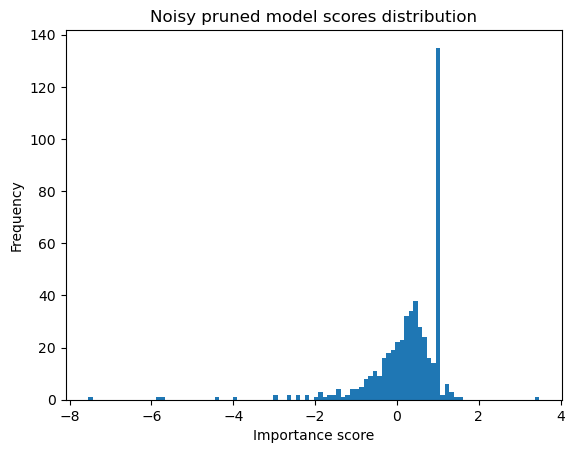

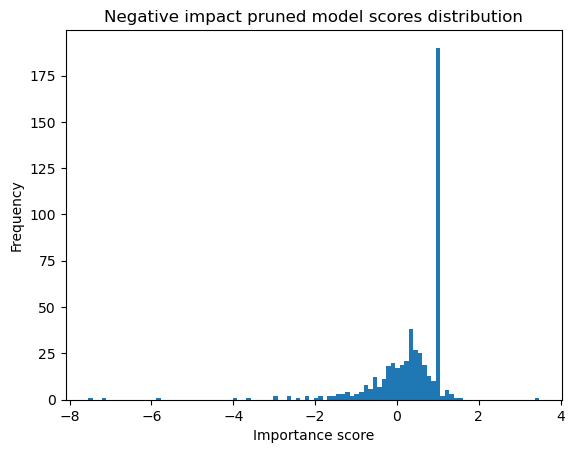

In [60]:
# Get just the first 5 elements of the validation dataset to test the functions above

OUTPUT_DIR_BASE = 'Heatmap_images/base_model'
OUTPUT_DIR_NOISY = 'Heatmap_images/noisy_pruned_model'
OUTPUT_DIR_NEG_IMPACT = 'Heatmap_images/negative_impact_pruned_model'

channel_importance_scores = z_scored_importance_scores
# Extracted features (Batch size 20, 512 channels, 14x14 spatial dimensions)
batch_features_base = layer_28_feature_maps_base
batch_features_noisy = layer_28_feature_maps_noisy
batch_features_neg_impact = layer_28_feature_maps_neg_impact

# Extract removed channels indices from the pruned models
noisy_removed_channels, _ = get_zeroed_feature_maps(noisy_pruned_model, 'features.28')
negative_impact_removed_channels, _ = get_zeroed_feature_maps(negative_impact_pruned_model, 'features.28')

print(noisy_removed_channels)
print(negative_impact_removed_channels)

def selective_importance_with_ignored_indices(original_scores, indices_to_ignore):
    """
    Keep the original values of an array except for specific indices which are set to 1.
    
    Args:
        original_scores: 1D array of scores with length 512
        indices_to_ignore: Indices where values should be set to 1 (not normalized)
        
    Returns:
        Modified array where indices in indices_to_ignore are set to 1
        and all other values the original values
    """
    modified_scores = original_scores.copy()
    modified_scores[indices_to_ignore] = 1
    return modified_scores

# Apply selective importance to the noisy pruned model
baseline_scores = np.ones(512)
noisy_scores = selective_importance_with_ignored_indices(channel_importance_scores, noisy_removed_channels)
negative_impact_scores = selective_importance_with_ignored_indices(channel_importance_scores, negative_impact_removed_channels)

# print the distribution of the noisy scores
plt.hist(noisy_scores, bins=100)
plt.title('Noisy pruned model scores distribution')
plt.xlabel('Importance score')
plt.ylabel('Frequency')
plt.show()

# print the distribution of the negative impact scores
plt.hist(negative_impact_scores, bins=100)
plt.title('Negative impact pruned model scores distribution')
plt.xlabel('Importance score')
plt.ylabel('Frequency')
plt.show()




In [61]:


heatmap_list_base = create_heatmaps_from_dataloader(test_functions_dataloader, batch_features_base,baseline_scores,OUTPUT_DIR_BASE)

heatmap_list_noisy = create_heatmaps_from_dataloader(test_functions_dataloader, batch_features_noisy, noisy_scores, OUTPUT_DIR_NOISY)

heatmap_list_neg_impact = create_heatmaps_from_dataloader(test_functions_dataloader, batch_features_neg_impact, negative_impact_scores, OUTPUT_DIR_NEG_IMPACT)



/tmp/ipykernel_823987/716838731.py:181: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(colormap)


Processed image 0
Processed image 1
Processed image 2
Processed image 3
Processed image 4
Processed image 5
Processed image 6
Processed image 7
Processed image 8
Processed image 9
Processed image 10
Processed image 11
Processed image 12
Processed image 13
Processed image 14
Processed image 15
Processed image 16
Processed image 17
Processed image 18
Processed image 19
Completed batch 1/1
Processed image 0
Processed image 1
Processed image 2
Processed image 3
Processed image 4
Processed image 5
Processed image 6
Processed image 7
Processed image 8
Processed image 9
Processed image 10
Processed image 11
Processed image 12
Processed image 13
Processed image 14
Processed image 15
Processed image 16
Processed image 17
Processed image 18
Processed image 19
Completed batch 1/1
Processed image 0
Processed image 1
Processed image 2
Processed image 3
Processed image 4
Processed image 5
Processed image 6
Processed image 7
Processed image 8
Processed image 9
Processed image 10
Processed image 11
Pr

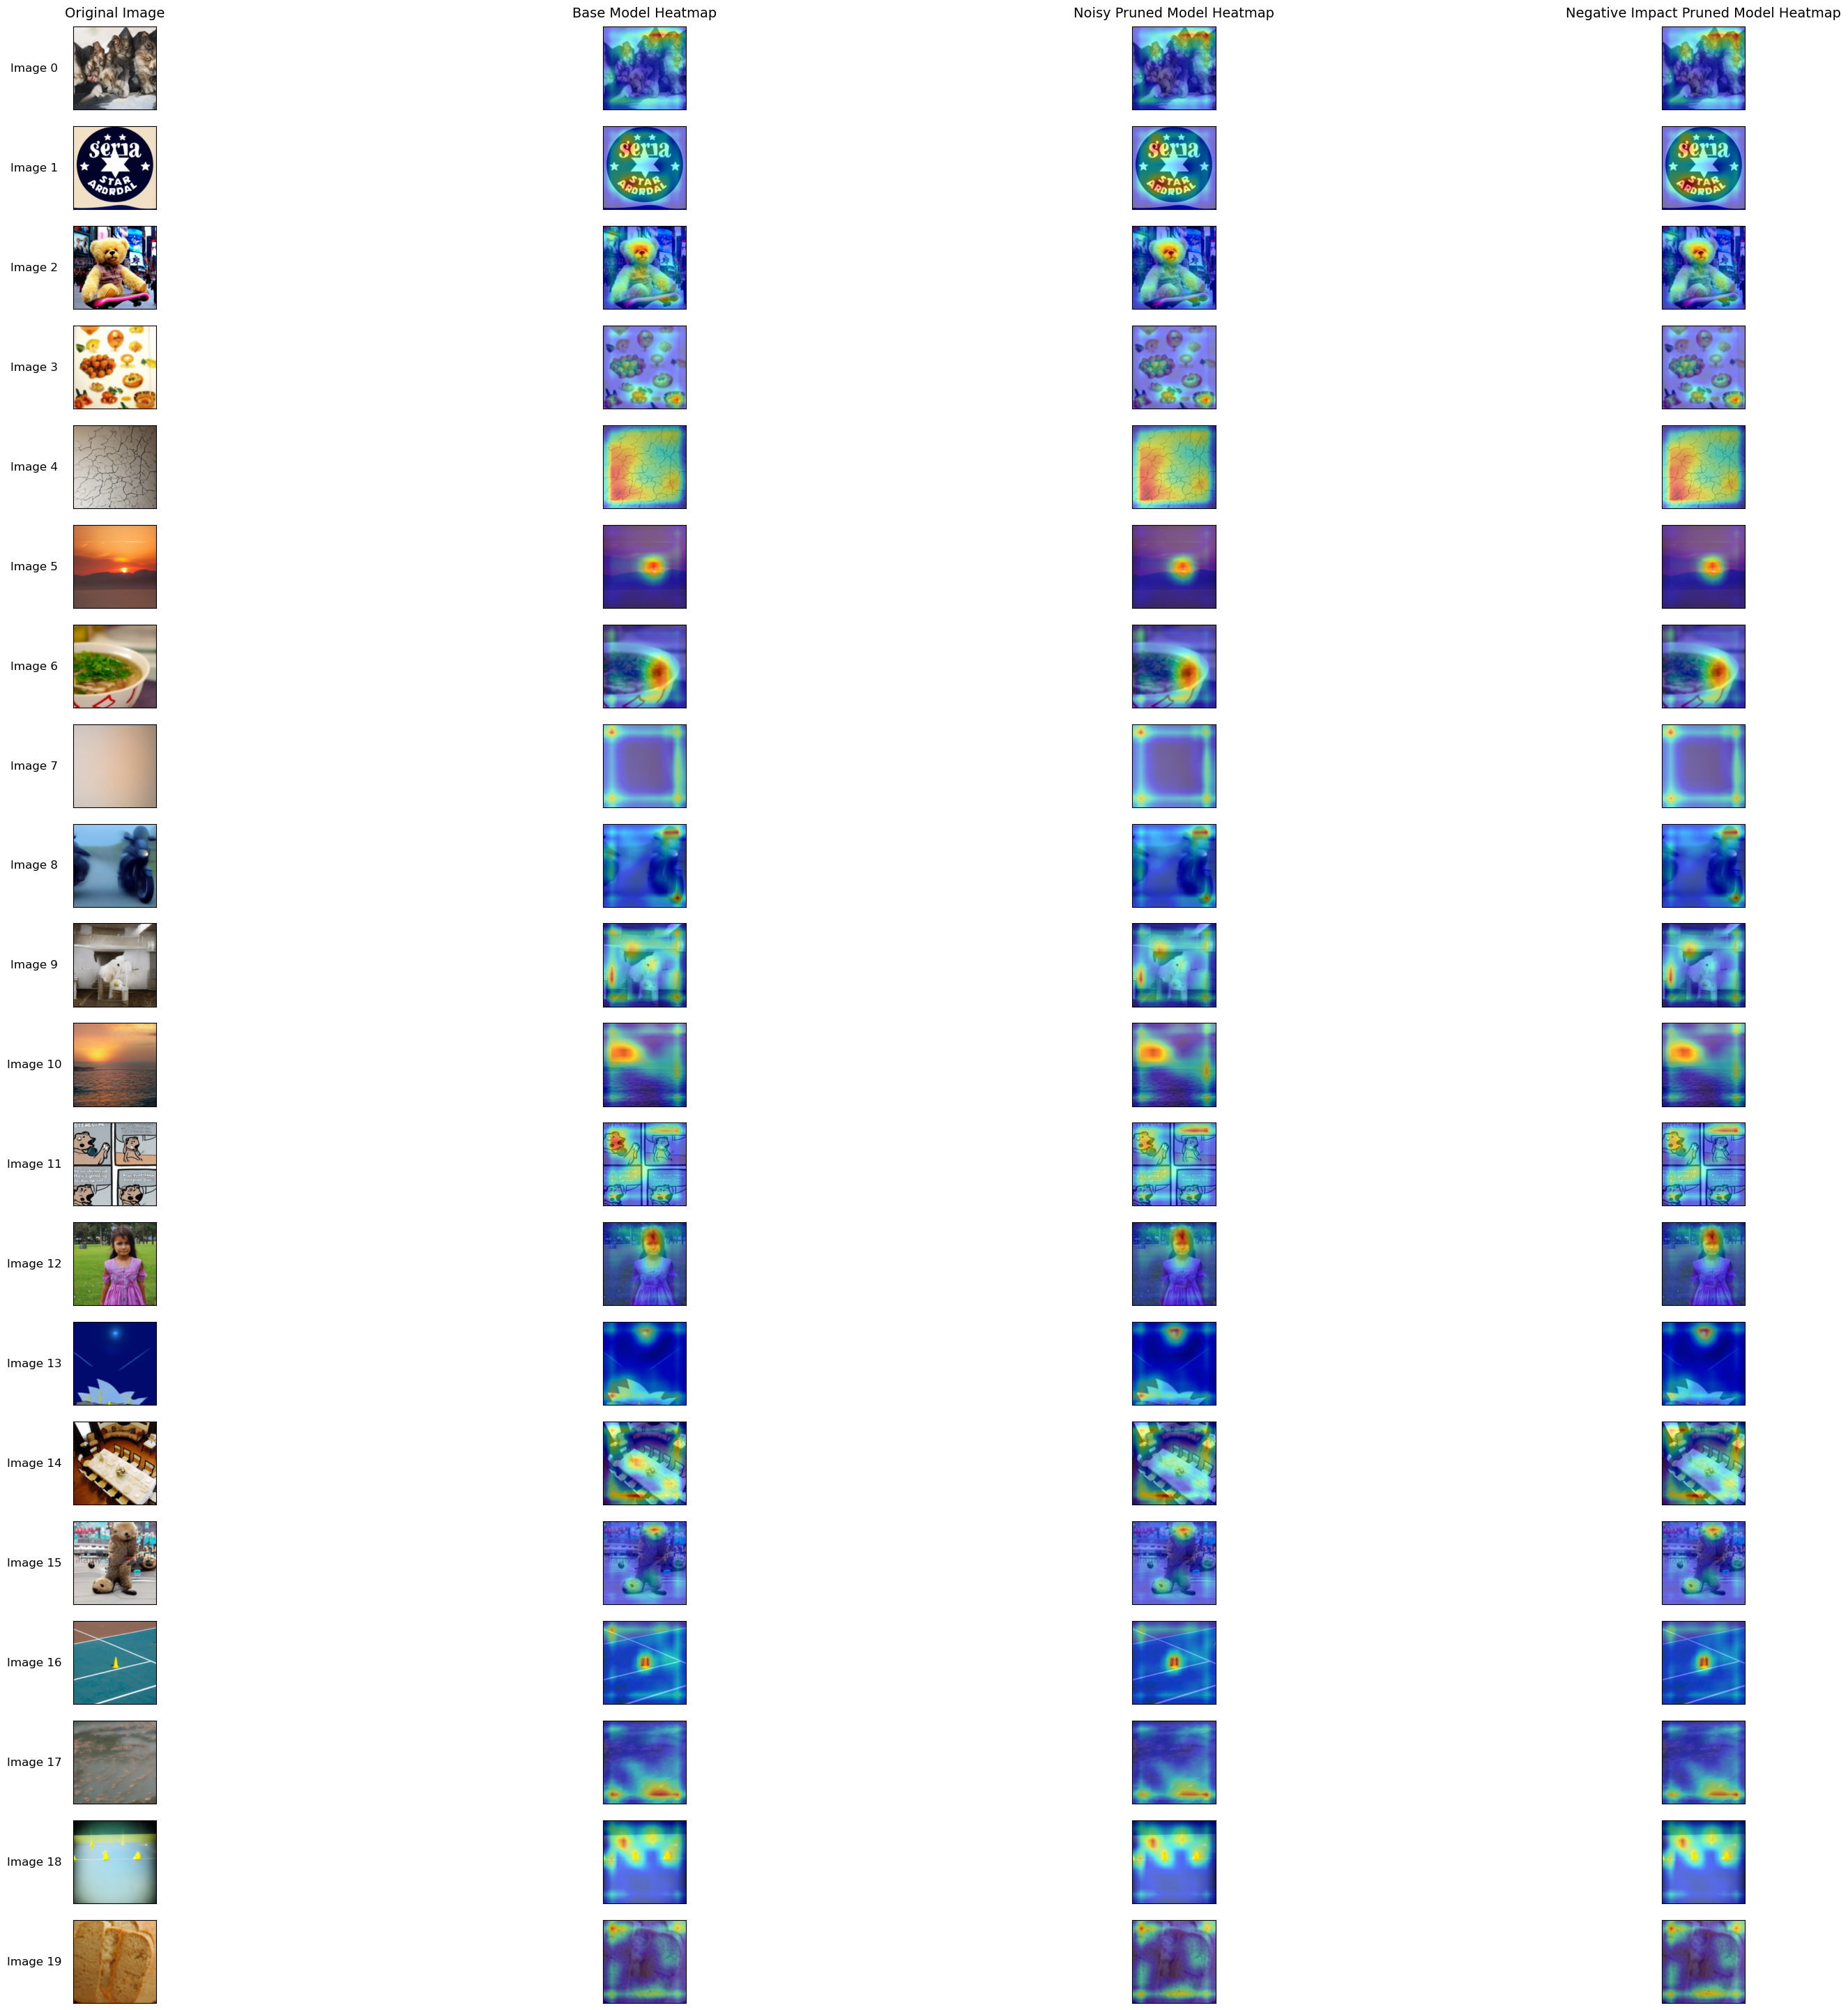

In [16]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os

def display_image_comparison(num_images=5, figsize=(20, 15)):
    """
    Display a comparison grid of images showing original images and their corresponding heatmaps
    from different models.
    
    Parameters:
    -----------
    num_images : int, default=5
        Number of different images to display (rows in the grid)
    figsize : tuple, default=(20, 15)
        Figure size for the plot
    """
    # Create figure and axes
    fig, axs = plt.subplots(num_images, 4, figsize=figsize)
    
    # Define column titles
    col_titles = ['Original Image', 'Base Model Heatmap', 
                 'Noisy Pruned Model Heatmap', 'Negative Impact Pruned Model Heatmap']
    
    # Set column titles at the top of the grid
    for col, title in enumerate(col_titles):
        axs[0, col].set_title(title, fontsize=14, pad=10)
    
    # Define folder paths
    folders = [
        'Heatmap_images/original_images/',
        'Heatmap_images/base_model/',
        'Heatmap_images/noisy_pruned_model/',
        'Heatmap_images/negative_impact_pruned_model/'
    ]
    
    # Image file patterns
    patterns = [
        'original_img_idx{}.png',
        'heatmap_img_idx{}.png',
        'heatmap_img_idx{}.png',
        'heatmap_img_idx{}.png'
    ]
    
    # Load and display each image
    for row in range(num_images):
        # Add row label (image index)
        axs[row, 0].set_ylabel(f'Image {row}', fontsize=12, rotation=0, labelpad=40, va='center')
        
        for col in range(4):
            # Construct image path
            img_path = os.path.join(folders[col], patterns[col].format(row))
            
            # Check if file exists
            if os.path.exists(img_path):
                try:
                    img = mpimg.imread(img_path)
                    axs[row, col].imshow(img)
                except Exception as e:
                    axs[row, col].text(0.5, 0.5, f"Error loading image:\n{str(e)}", 
                                      ha='center', va='center', color='red')
            else:
                axs[row, col].text(0.5, 0.5, f"File not found:\n{img_path}", 
                                  ha='center', va='center', color='red')
            
            # Turn off axis ticks
            axs[row, col].set_xticks([])
            axs[row, col].set_yticks([])
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.95, wspace=0.1, hspace=0.2)
    
    # Save the figure (optional)
    plt.savefig('heatmap_comparison.png', dpi=300, bbox_inches='tight')
# Call the function to display the images
display_image_comparison(num_images=20, figsize=(30, 30))


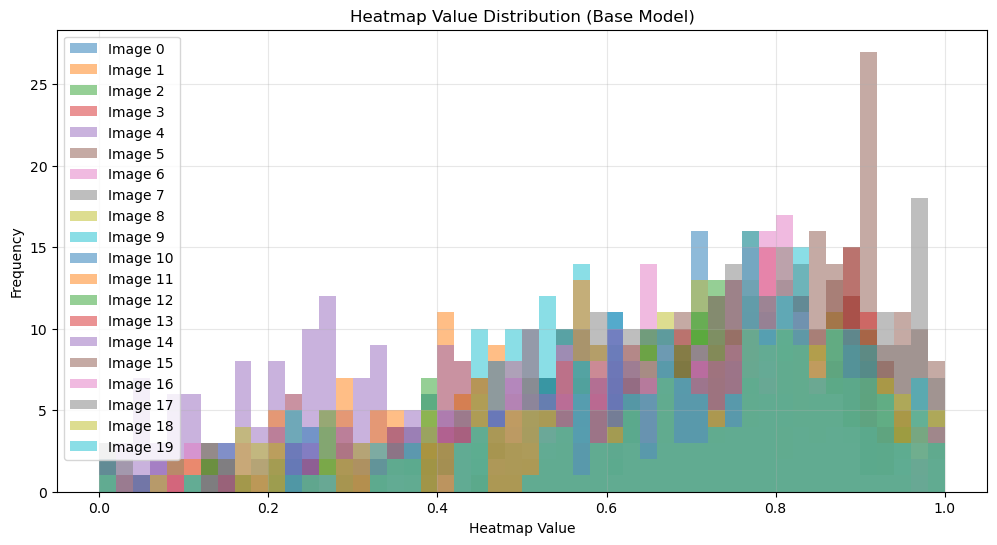

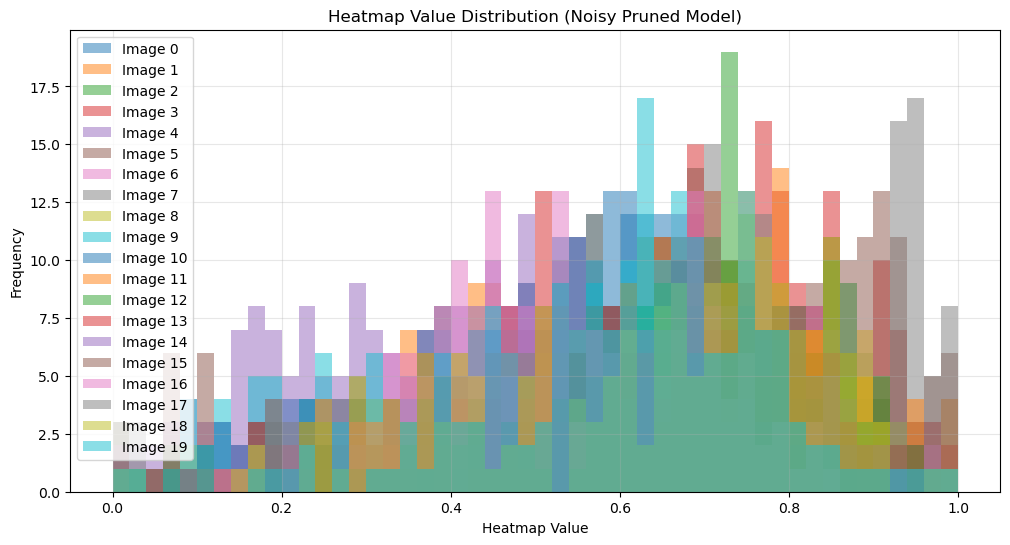

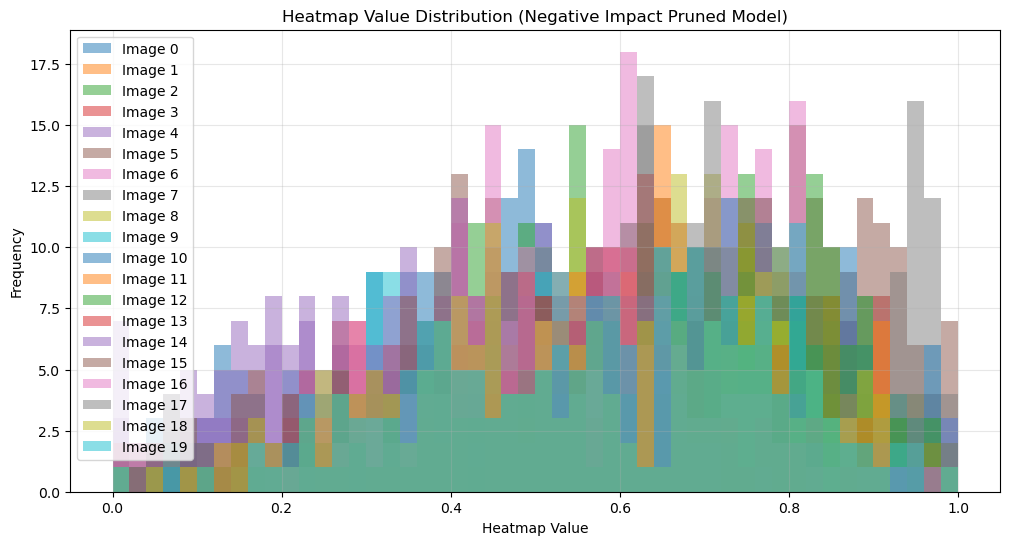

In [62]:
# plot the distributions of the 14x14 heatmaps created for the first 5 images in the validation set

def plot_heatmap_distributions(heatmaps, model_name):
    """
    Plot the distribution of values in the heatmaps.
    
    Args:
        heatmaps (list): List of heatmaps (numpy arrays).
        model_name (str): Name of the model for the plot title.
    """
    plt.figure(figsize=(12, 6))
    
    for i, heatmap in enumerate(heatmaps):
        # Flatten the heatmap
        heatmap_flat = heatmap.flatten()
        
        # Plot histogram
        plt.hist(heatmap_flat, bins=50, alpha=0.5, label=f'Image {i}')
    
    plt.title(f'Heatmap Value Distribution ({model_name})')
    plt.xlabel('Heatmap Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
# Plot the heatmap distributions for the three models
plot_heatmap_distributions(heatmap_list_base, 'Base Model')
plot_heatmap_distributions(heatmap_list_noisy, 'Noisy Pruned Model')
plot_heatmap_distributions(heatmap_list_neg_impact, 'Negative Impact Pruned Model')
